In [ ]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
import pickle as pkl
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from pytorch3d.renderer import PerspectiveCameras, PointLights, MeshRenderer, MeshRasterizer, RasterizationSettings, SoftPhongShader
from pytorch3d.renderer import TexturesVertex, Materials
from pytorch3d.structures import Meshes

from hmr4d.dataset.h36m.h36m import H36mSmplDataset #6,196 samples
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.geo.hmr_global import get_c_rootparam, get_R_c2gv
from hmr4d.utils.vis.renderer import Renderer, update_intrinsics_from_bbox, compute_bbox_from_points

device = 'cuda:0'

In [2]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).to(device)
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").to(device)
faces_smpl = torch.from_numpy((smpl.faces).astype("int")).unsqueeze(0).to(device)
faces_smplx = torch.from_numpy((smplx.faces).astype("int")).unsqueeze(0).to(device)
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").to(device)

In [ ]:
def get_backg_image(vid, idx):
    root_dir = Path("/home/guangyu/qucheng/RegDA_tokenpose/data/Human36M/images")
    camera_idx_to_name = {"54138969": 1, "55011271": 2, "58860488": 3, "60457274": 4}

    subject = int(vid.split('@')[0].replace('S', ''))
    action_name = vid.split('@')[1].rsplit('_', 1)[0]
    subaction_idx = int(vid.split('@')[1].rsplit('_', 1)[1])
    cam_idx = camera_idx_to_name[vid.split('@')[2]]

    tmp = json.loads(Path(f"/home/guangyu/qucheng/RegDA_tokenpose/data/Human36M/annotations/Human36M_subject{subject}_data.json").read_text())
    df = pd.DataFrame(tmp['images'])
    frame_list = df.loc[((df.subject == subject) & (df.action_name == action_name) & (df.subaction_idx == subaction_idx) & (df.cam_idx == cam_idx))]
    frame_name = frame_list.loc[frame_list.frame_idx == idx * 2].file_name.values[0]
    backg = cv2.imread(str(root_dir / frame_name))[...,::-1]
    return backg


[12/26 11:27:39][INFO] [H36M] Loading from inputs/H36M/hmr4d_support/smplxpose_v1.pt ...
[12/26 11:27:39][INFO] [H36M] 600 sequences. Elapsed: 0.62s
[12/26 11:27:39][INFO] [H36M] Fully Loading to RAM ViT-Feat: inputs/H36M/hmr4d_support/vitfeat_h36m.pt
[12/26 11:27:39][INFO] [H36M] Finished. Elapsed: 0.44s
[12/26 11:27:39][INFO] [H36M] has 8.7 hours motion -> Resampled to 6196 samples.


{'data_name': 'h36m', 'idx': 5, 'vid': 'S1@Smoking_1@54138969', 'start_end': (1146, 1266)}


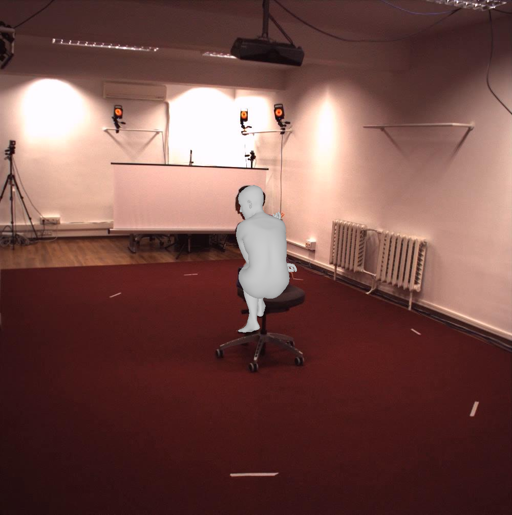

In [26]:
dataset = H36mSmplDataset()

np.random.seed(4)
batch = dataset[5]
print(batch['meta'])

K = batch['K_fullimg'][0].to(device)
width, height = int(K[0,2])*2, int(K[1,2])*2
smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
verts = smplx(**smpl_params_c).vertices

i = 0
vid = batch['meta']['vid']
idx = batch['meta']['start_end'][0] + i
backg = get_backg_image(vid, idx)

renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K)
img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
Image.fromarray(img).resize((width//2, height//2))

In [ ]:
root = Path("inputs/H36M/hmr4d_support")
motion_files = torch.load(root / "smplxpose_v1.pt")
f_img_dicts = torch.load(root / "vitfeat_h36m.pt")

vid = 'S1@Smoking_1@54138969'
idx = 250

motion = motion_files[vid]
f_img_dict = f_img_dicts[vid]

smpl_params_w = {k: v[idx].unsqueeze(0).to(device) for k, v in motion["smpl_params_glob"].items()}
T_w2c = motion["cam_Rt"]
K = f_img_dict["K_fullimg"].unsqueeze(0).float().to(device)

offset = smplx.get_skeleton(smpl_params_w["betas"][0])[0]  # (3)
global_orient_c, transl_c = get_c_rootparam(
    smpl_params_w["global_orient"], smpl_params_w["transl"], T_w2c.to(device), offset,
)
smpl_params_c = {
    "body_pose": smpl_params_w["body_pose"].clone(),  # (F, 63)
    "betas": smpl_params_w["betas"].clone(),  # (F, 10)
    "global_orient": global_orient_c,  # (F, 3)
    "transl": transl_c,  # (F, 3)
}
vertices_c = smplx(**smpl_params_c).vertices

gravity_vec = torch.tensor([0, 0, -1]).float()  # (3), H36M is az
R_c2gv = get_R_c2gv(T_w2c[..., :3, :3], axis_gravity_in_w=gravity_vec)  # (F, 3, 3)

backg = get_backg_image(vid, idx)

In [ ]:
## Renderer
width, height = int(K[0, 0, 2]) * 2, int(K[0, 1, 2]) * 2

## initialize_camera_params
R = torch.diag(torch.tensor([1, 1, 1])).float().to(device).unsqueeze(0)
T = torch.tensor([0, 0, 0]).unsqueeze(0).float().to(device)
# bboxes = torch.tensor([[0, 0, width, height]]).float()
# K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)

## update_bbox
## perspective_projection
x3d = vertices_c[0, ::50].unsqueeze(0).clone()
x3d = torch.matmul(R, x3d.transpose(1, 2)).transpose(1, 2)
x3d = x3d + T.unsqueeze(-1).transpose(1, 2)
x2d = torch.div(x3d, x3d[..., 2:])
x2d = torch.matmul(K, x2d.transpose(-1, -2)).transpose(-1, -2)[..., :2]
    
bboxes = compute_bbox_from_points(x2d, width, height, 1.2)
print(bboxes)
K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)
cameras = PerspectiveCameras(device=device, R=R.mT, T=T, K=K_full, image_size=image_sizes, in_ndc=False)

lights = PointLights(device=device, location=[[0.0, 0.0, -10.0]])

## create_renderer
raster_settings = RasterizationSettings(image_size=image_sizes[0], blur_radius=1e-5, bin_size=None)
rasterizer = MeshRasterizer(raster_settings=raster_settings)
shader = SoftPhongShader(device=device, lights=lights)

renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

tensor[1, 4] x∈[246.000, 678.000] μ=458.750 σ=183.865 cuda:0 [[392.000, 246.000, 519.000, 678.000]]


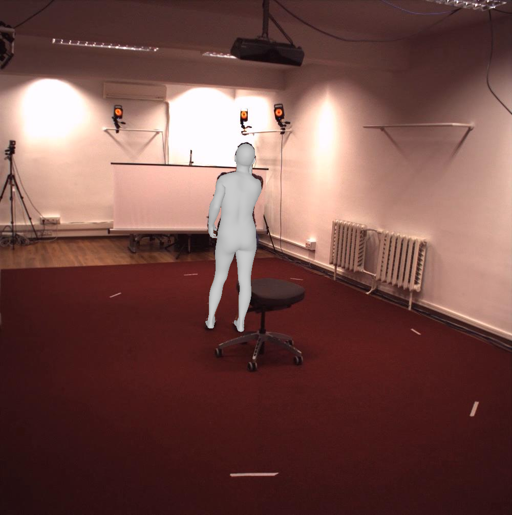

In [ ]:
# img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
verts_features = torch.tensor([0.8,0.8,0.8]).reshape(1, 1, 3).to(device=device, dtype=vertices_c.dtype)
verts_features = verts_features.repeat(1, vertices_c.shape[1], 1)
textures = TexturesVertex(verts_features=verts_features)

mesh = Meshes(verts=vertices_c, faces=faces_smplx, textures=textures,)

materials = Materials(device=device, specular_color=([0.8, 0.8, 0.8],), shininess=0)

results = torch.flip(renderer(mesh, materials=materials, cameras=cameras, lights=lights), [1, 2])
image = (results[0, ..., :3].detach().cpu().numpy() * 255).astype(np.uint8)
mask = (results[0, ..., -1].detach().cpu().numpy() > 1e-3).astype(bool)

out_image = backg.copy()
bbox = bboxes[0].int().cpu().numpy().copy()
roi_image = out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
roi_image[mask] = image[mask]
out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]] = roi_image
Image.fromarray(out_image).resize((width//2, height//2))

In [83]:
root = Path("inputs/H36M/hmr4d_support")
motion_files = torch.load(root / "smplxpose_v1.pt")
f_img_dicts = torch.load(root / "vitfeat_h36m.pt")

vid = 'S1@Smoking_1@54138969'
idx = 500

motion = motion_files[vid]
f_img_dict = f_img_dicts[vid]

smpl_params_w = {k: v[idx].unsqueeze(0).to(device) for k, v in motion["smpl_params_glob"].items()}
T_w2c = motion["cam_Rt"]
K = f_img_dict["K_fullimg"].unsqueeze(0).float().to(device)

smplx_w = smplx(**smpl_params_w)

verts, joints = smplx_w.vertices, smplx_w.joints

In [84]:
# move_to_start_point_face_z
from einops import einsum
from hmr4d.utils.geo_transform import compute_T_ayfz2ay, apply_T_on_points

verts = smplx_w.vertices.clone()  # (L, V, 3)
offset = einsum(smplx.bm.J_regressor, verts[0], "j v, v i -> j i")[0]  # (3)
offset[1] = verts[:, :, [1]].min()
verts = verts - offset
# face direction
T_ay2ayfz = compute_T_ayfz2ay(einsum(smplx.bm.J_regressor, verts[[0]], "j v, l v i -> l j i"), inverse=True)
verts = apply_T_on_points(verts, T_ay2ayfz)
joints = einsum(smplx.bm.J_regressor, verts, "j v, l v i -> l j i")  # (L, J, 3)


In [85]:
from hmr4d.utils.vis.renderer import Renderer, get_global_cameras_static, get_ground_params_from_points
from hmr4d.utils.geo.hmr_cam import create_camera_sensor

global_R, global_T, global_lights = get_global_cameras_static(
    joints.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0,
)
_, _, K = create_camera_sensor(width, height, 24)
renderer_g = Renderer(width, height, device="cuda", faces=faces_smplx[0], K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(joints[:, 0], verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8

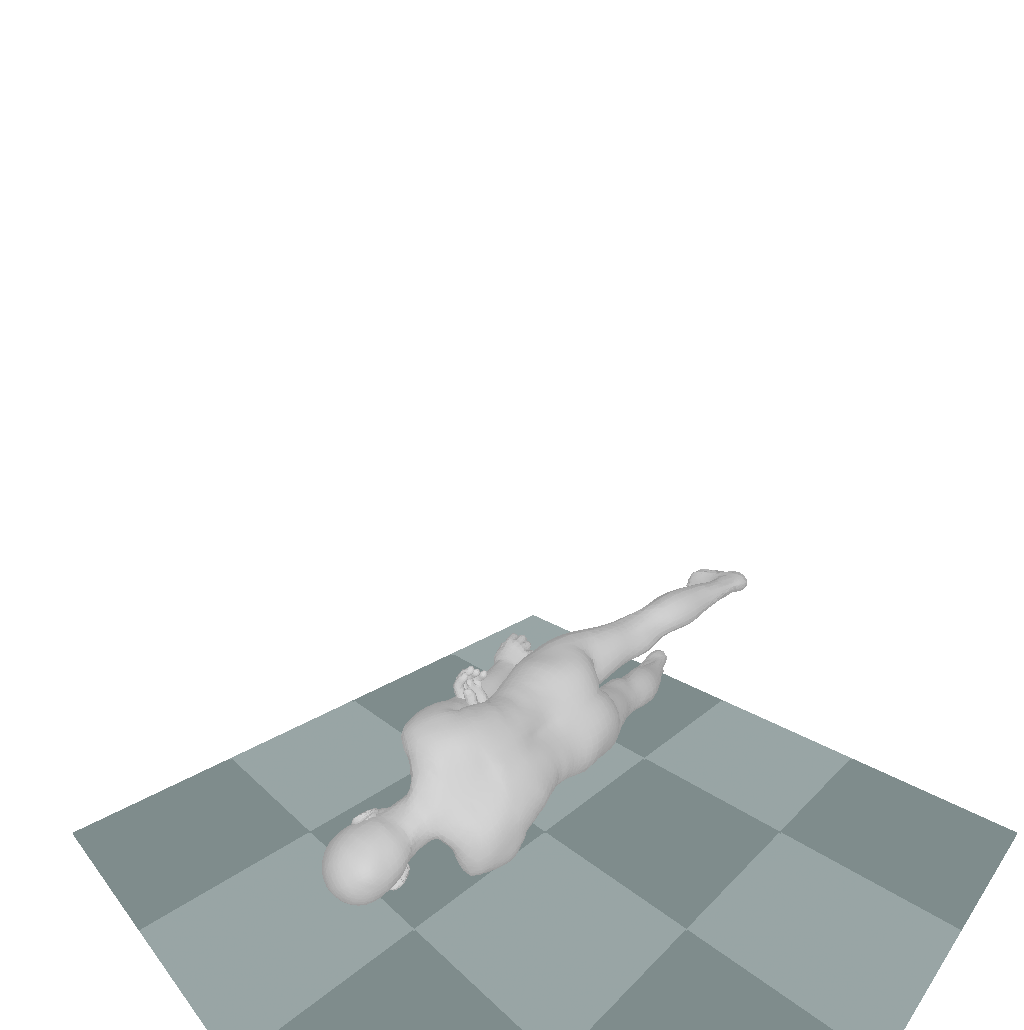

In [86]:
cameras = renderer_g.create_camera(global_R, global_T)
img_gb = renderer_g.render_with_ground(verts, color[None], cameras, global_lights)
Image.fromarray(img_gb)